# **Required imports**


In [1]:
import sys
#SRC_PATH = '/content/gdrive/My Drive/Colab Notebooks/TetrisEngine' # CHANGE ACCORDINGLY
#SRC_PATH = '/content/gdrive/My Drive/Colab Notebooks/DL2020/Final project'
SRC_PATH = './'
sys.path.append(SRC_PATH)

import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
import cv2
from time import sleep

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from collections import deque
import pickle

import itertools as it

C:\Users\Sam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Mount Drive

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# **Importing the Tetris env**


In [3]:
from engine import TetrisEngine

# **Setting some parameters**
This way we get rid of these "magic numbers"

In [4]:
ROTATE_LEFT_ACTION = 0
ROTATE_RIGHT_ACTION = 1
RIGHT_ACTION = 2
LEFT_ACTION = 3
SOFT_DROP_ACTION = 4
HARD_DROP_ACTION = 5

AGENT_OBSERVATION_SPACE = (20,10,1)
AGENT_ACTION_SPACE = [ROTATE_LEFT_ACTION,ROTATE_RIGHT_ACTION,RIGHT_ACTION,LEFT_ACTION,SOFT_DROP_ACTION, HARD_DROP_ACTION]
AGENT_ACTION_SPACE_REDUCED = [ROTATE_LEFT_ACTION,RIGHT_ACTION,LEFT_ACTION, HARD_DROP_ACTION]

def INPUT_MAP(inp):
  # 0 -> 0
  # 1 -> 2
  # 2 -> 3
  # 3 -> 5

  if (inp == 0):
    return 0
  if (inp == 1):
    return 2
  if (inp == 2):
    return 3
  if (inp == 3):
    return 5
  



# **Defining the agent (includes the training)**

In [5]:
class Agent():
  def __init__(self, epsilon, epsilon_min, epsilon_decay, decay_change, epsilon_decay2):
    self.action_size = len(AGENT_ACTION_SPACE_REDUCED)
    self.observation_shape = AGENT_OBSERVATION_SPACE[0]*AGENT_OBSERVATION_SPACE[1]*AGENT_OBSERVATION_SPACE[2]

    self.memory  = deque()
    #self.reward_history = []
    
    self.gamma = 0.8

    self.epsilon = epsilon
    self.epsilon_min = epsilon_min
    self.epsilon_decay = epsilon_decay
    self.decay_change = decay_change
    self.epsilon_decay2 = epsilon_decay2

    self.learning_rate = 0.001
    self.tau = .05
    self.errors = []
    self.error_window_size = 100
    self.epochs = 1
    self.steps_since_target_update = 0
    self.steps_between_target_updates = 100
    self.replay_batch_size = 32
    self.steps_between_training = 32
    self.steps = 0

    # does the actual predictions on what action to take
    self.model = self.create_model()

    # tracks what action we want our model to take.
    # this network changes more slowly and tracks our eventual goal
    self.target_model = self.create_model()

  def log(self):
    loss = np.mean(self.errors)
    print("Epsilon="+str(self.epsilon)+
          ". Avg q-value prediction NRMSE="+str(loss))
    return self.epsilon, loss
        
  def get_action(self, observation):
    if(self.epsilon>self.decay_change):
        self.epsilon *= self.epsilon_decay
    else:
        self.epsilon*=self.epsilon_decay2
    self.epsilon = max(self.epsilon_min, self.epsilon)
    
    if(len(self.memory) < self.replay_batch_size or np.random.random() < self.epsilon):
      return random.choice(range(self.action_size))

    return np.argmax(self.model.predict(observation)[0])

  def remember(self, observation, action, reward, new_observation, done):
    self.memory.append([observation, action, reward, new_observation, done])
    """
    self.reward_history.append(np.abs(reward))
    if(len(self.reward_history) > self.avg_window_size):
      self.reward_history = self.reward_history[:-self.avg_window_size]
    """

  def create_model(self):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same',input_shape=(20, 10, 1)))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    #model.add(Dense(64, activation="relu"))
    model.add(Dense(self.action_size))

    model.compile(loss="mean_squared_error",
    optimizer=Adam(lr=self.learning_rate))

    return model

  def __save_model_weights(self, ep, filename):
    model_weights_path = SRC_PATH+"/"+filename+"_"+str(ep+1)+".h5f"
    target_model_weights_path = SRC_PATH+"/target_"+filename+"_"+str(ep+1)+".h5f"
    try:
      self.model.save_weights(model_weights_path, overwrite=True)
      self.target_model.save_weights(target_model_weights_path, overwrite=True)
      print("Model weights saved succesfully")
    except:
      print("Saving model weights failed. Continuing...")

  def __save_replay_buffer(self, ep, filename):
    buffer_path = SRC_PATH+"/"+filename+".pkl"
    """
    try:
      pickle.dump(self.memory, open(buffer_path, 'wb'))
      print("Replay buffer saved succesfully")
    except:
      print("Saving replay buffer failed. Continuing...")
    """

  def save_agent_state(self, ep, model_filename, buffer_filename):
    self.__save_model_weights(ep, model_filename)
    self.__save_replay_buffer(ep, buffer_filename)

  def replay(self):
    
    if (len(self.memory) < self.replay_batch_size or self.steps < self.steps_between_training): 
        self.steps+=1
        return
    
    self.steps=0
    
    for i in range(self.steps_between_training):
        batch = random.sample(self.memory, self.replay_batch_size)
        observations = np.array([x[0] for x in batch]).reshape(self.replay_batch_size, 20, 10, 1)
        new_observations = np.array([x[3] for x in batch]).reshape(self.replay_batch_size, 20, 10, 1)
        online_qs = self.model.predict(observations)
        target_qs = self.target_model.predict(new_observations)

        for i,sample in enumerate(batch):
             _, action, reward, _, done = sample
             if done:
                 online_qs[i][action] = reward
             else:
                 q_next = np.max(target_qs[i])
                 online_qs[i][action] = reward + q_next * self.gamma
        e = self.model.fit(observations, online_qs, epochs=self.epochs, verbose=0)
        self.errors.append(np.sqrt(np.mean(e.history["loss"]))/np.abs(np.mean(online_qs)))
        if(len(self.errors) > self.error_window_size):
            self.errors = self.errors[-self.error_window_size:]

  def target_train(self):
    self.steps_since_target_update += 1
    if self.steps_since_target_update >= self.steps_between_target_updates:
      weights = self.model.get_weights()
      self.target_model.set_weights(weights)
      self.steps_since_target_update = 0

# **Filters the memories that are used for training**

In [6]:
class MemoryFilter():
  def __init__(self, agent):
    self.agent = agent
    self.last_consulted_memory_item = None
    self.last_unconsulted_memory_item = None
    self.did_last_step_consult_agent = True

  def remember(self, do_consult_agent, memory_item): 
    # (1)
    # If we were not consulting the agent in the last step, but now we are (A new piece has been placed on top)
    # -> Remember joined memories of last_consulted_memory_item and last_unconsulted_memory_item
    if not self.did_last_step_consult_agent and do_consult_agent:
      self.agent.remember(*joinMemories(self.last_consulted_memory_item, self.last_unconsulted_memory_item))            
      self.agent.replay()       # internally iterates default (prediction) model
      self.agent.target_train() # iterates target model

      self.last_consulted_memory_item = None
      self.last_unconsulted_memory_item = None

    # (2)
    # Do certain checks on item
    # eg. nparray filled with zeros will be discarded
    # eg. discard memory where no action is taken
    valid_memory_item = True

    # Stop if invalid
    if not valid_memory_item:
      return;

    # (3)
    if do_consult_agent:
      self.agent.remember(*memory_item)            
      self.agent.replay()       # internally iterates default (prediction) model
      self.agent.target_train() # iterates target model
      # save last memory-item in which the agent was consulted
      self.last_consulted_memory_item = memory_item

    else:
      self.last_unconsulted_memory_item = memory_item

  def joinMemories(memoryA, memoryB):
    return [memoryA[3], memoryB[1], memoryB[2], memoryB[3], memoryB[4]]


# **Reward function**

In [80]:
# REMARK: The new engine's state also includes 2's (for the current block) besides 0's and 1's

import engine
import copy

def custom_reward6(previous_state, current_state, new_block): #=custom_reward5 + block reward
    BLOCK_FACTOR = 1
    reward, stop = custom_reward5(previous_state, current_state)# Reward based on the difference in y-coordinates 
                                                                # of the centroid of the subsequent states 
                                                                # + density of lines
    if(new_block):
        reward+=BLOCK_FACTOR # Add block award if new block appears (and thus previous one was placed succesfully)
    return reward, stop
    

# Reward based on the difference in y-coordinates of the centroid of the subsequent states + density of lines
def custom_reward5(previous_state, current_state):
    
    CENTROID_REWARD_FACTOR = 10
    WIDTH_REWARD_FACTOR = 3
    MAX_HEIGHT = 10
    stop = False
    
    h = engine.height(current_state)
    if(h>MAX_HEIGHT):
        stop = True
    
    previous_state = copy.deepcopy(previous_state)
    previous_state[previous_state == 2] = 0
    current_state = copy.deepcopy(current_state)
    current_state[current_state == 2] = 0
    
    cy_previous = centroid_y(previous_state)
    cy_current = centroid_y(current_state)
    
    pvs_w = max_width(previous_state)
    c_w = max_width(current_state)
    
    centroid_reward = (cy_previous - cy_current)*CENTROID_REWARD_FACTOR
    width_reward = max(c_w - pvs_w, 0)*WIDTH_REWARD_FACTOR
    
    return centroid_reward + width_reward, stop

def centroid_y(state):
    BOARD_HEIGHT = 20
    hist = state.sum(1)
    w = hist.sum()
    if(w==0):
        return 0
    s = 0
    for i,x in enumerate(hist):
        s+=(BOARD_HEIGHT-1-i)*x
    return s/w

def custom_reward4(previous_state, current_state):
  HEIGHT_REWARD_FACTOR = 1
  WIDTH_REWARD_FACTOR = 1
  MAX_HEIGHT = 10
  stop = False

  previous_state = copy.deepcopy(previous_state)
  previous_state[previous_state == 2] = 0

  current_state = copy.deepcopy(current_state)
  current_state[current_state == 2] = 0

  pvs_h = engine.height(previous_state)
  c_h = engine.height(current_state)
  if(c_h>MAX_HEIGHT):
    stop = True

  pvs_w = max_width(previous_state)
  c_w = max_width(current_state)  

  height_reward = (pvs_h - c_h)*HEIGHT_REWARD_FACTOR
  width_reward = max(c_w - pvs_w,0)*WIDTH_REWARD_FACTOR

  return height_reward + width_reward, stop

def max_width(state):
    LINES_TO_EXPLORE = 10
    h = state.shape[0]
    w = state.shape[1]
    widths = []
    for i in range(LINES_TO_EXPLORE):
        widths.append(get_width(state[h-1-i]))
    return max(widths)

def get_width(a):
    cnt = 0
    res = 0
    n = len(a)
    for i in range(n):
        if(a[i]==0):
            cnt = 0
        else:
            cnt+=1
            res = max(res,cnt)
    return res

def custom_reward3(state, steps, done, new_block):
  MIN_STEPS_PER_EP = 1000
  stop=False
  h = engine.height(state)
  w = max_width(state)
  if(not(new_block)):
    return 0, stop
  else:
    if(w<=5):
      width_reward = -100*(10-w)
    else:
      width_reward = 100*w

    if(h>=10):
      steps_reward = steps - MIN_STEPS_PER_EP
      height_reward = -1000*(h-5)
      stop = True
    elif(h<=4):
      steps_reward = 0
      height_reward = 1000*(5-h)
    else:
      steps_reward = 0
      height_reward = 0
    
    return width_reward + height_reward + steps_reward, stop

def custom_reward2(state):
  try:
    l = info['number_of_lines']
  except:
    l = 0
  h = engine.height(state)
  r = custom_reward(state)
  if(h>=10):
    return r-10000 + l*1000
  elif(h<=4):
    return r+10000 + l*1000
  else:
    return r + l*1000

# reward parameters
a = -0.510066
b = 0.760666
c = -0.35663
d = -0.184483

def custom_reward(new_observation):
    new_observation = new_observation.reshape(20,10)

    # ignore current piece area
    for x in range(0, 5):
        new_observation = np.delete(new_observation, 0, 0)

    aggregate_height = compute_aggregate_height(new_observation)
    complete_lines = compute_complete_lines(new_observation)
    holes = compute_holes(new_observation)
    bumpiness = compute_bumpiness(new_observation)
    return a * aggregate_height + b * complete_lines + c * holes + d * bumpiness


# REMARK: Similar functions exist in engine.py
def compute_aggregate_height(observation):
    aggregate_height = 0
    for column in observation.T:
        aggregate_height += compute_column_height(column)
    return aggregate_height

def compute_complete_lines(observation):
    return  (observation.sum(axis=1) == 10).sum()


def compute_holes(observation):
    holes = 0
    for column in observation.T:
        prev_point = 0
        for point in column:
            if prev_point == 1 and point == 0:
                holes += 1
            prev_point = point 
    return holes

def compute_bumpiness(observation):
    bumpiness = 0
    prev_height = None
    for column in observation.T:
        column_height = compute_column_height(column)
        if prev_height != None:
            bumpiness += abs(column_height - prev_height)
        prev_height = column_height
    return bumpiness

# REMARK: Similar functions exist in engine.py
def compute_column_height(column):
    height = 0
    found_top = False
    for point in column:
        if not found_top:
            found_top = point == 1        
        if found_top:
            height += 1
    return height

# Some code for plots

In [8]:
import matplotlib.pyplot as plt

def make_plots(total_rewards, custom_rewards, epsilons, losses, scores, lines, steps):
  MOVING_AVERAGE_N = 50

  movav_total_rewards = np.convolve(total_rewards, np.ones((MOVING_AVERAGE_N,))/MOVING_AVERAGE_N, mode='valid')
  plt.plot(np.arange(len(total_rewards)), total_rewards)
  plt.plot(np.arange(len(total_rewards) - MOVING_AVERAGE_N + 1) + MOVING_AVERAGE_N - 1, movav_total_rewards, linewidth=2)
  plt.xlabel("Episode")
  plt.ylabel("Reward")
  plt.grid()
  plt.show()

  movav_custom_rewards = np.convolve(custom_rewards, np.ones((MOVING_AVERAGE_N,))/MOVING_AVERAGE_N, mode='valid')
  plt.plot(np.arange(len(custom_rewards)), custom_rewards)
  plt.plot(np.arange(len(custom_rewards) - MOVING_AVERAGE_N + 1) + MOVING_AVERAGE_N - 1, movav_custom_rewards, linewidth=2)
  plt.xlabel("Episode")
  plt.ylabel("Reward")
  plt.grid()
  plt.show()

  plt.plot(np.arange(len(epsilons)), epsilons)
  plt.xlabel("Episode")
  plt.ylabel("Epsilon")
  plt.grid()
  plt.ylim(0,1)
  plt.show()

  MOVING_AVERAGE_N = 10
  movav_losses = np.convolve(losses, np.ones((MOVING_AVERAGE_N,))/MOVING_AVERAGE_N, mode='valid')
  plt.plot(np.arange(len(losses)), losses)
  plt.plot(np.arange(len(losses) - MOVING_AVERAGE_N + 1) + MOVING_AVERAGE_N - 1, movav_losses)
  plt.xlabel("Episode")
  plt.ylabel("Loss")
  plt.grid()
  plt.ylim(0,10)
  plt.show()

  MOVING_AVERAGE_N = 50

  plt.plot(np.arange(len(scores)), scores)
  plt.xlabel("Episode")
  plt.ylabel("Game score")
  plt.grid()
  plt.show()

  plt.plot(np.arange(len(lines)), lines)
  plt.xlabel("Episode")
  plt.ylabel("Number of cleared lines")
  plt.grid()
  plt.show()

  movav_steps = np.convolve(steps, np.ones((MOVING_AVERAGE_N,))/MOVING_AVERAGE_N, mode='valid')
  plt.plot(np.arange(len(steps)), steps)
  plt.plot(np.arange(len(steps) - MOVING_AVERAGE_N + 1) + MOVING_AVERAGE_N - 1, movav_steps)
  plt.xlabel("Episode")
  plt.ylabel("Number of steps")
  plt.grid()
  plt.show()


# Trying some epsilon values

-6908


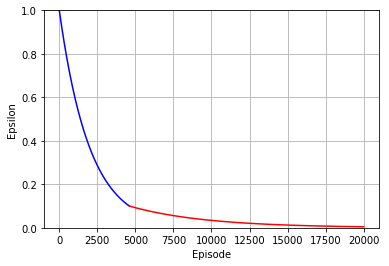

In [79]:
#TODO: add plot for changing decay

episodes = 20000
mean_steps = 100

epsilon = 0.9999
epsilon_min = 0.01
epsilon_decay = 0.999995
decay_change = 0.1
epsilon_decay2 = 0.999998

epsilon_projection = np.arange(episodes*mean_steps) 
epsilon_projection = np.power(epsilon_decay, epsilon_projection)
mask = epsilon_projection < decay_change
epsilon_projection[mask] = None
epsilon_projection = epsilon_projection[::mean_steps]
idx1 = [i for i,x in enumerate(epsilon_projection) if np.isnan(x)][0] - 1
plt.plot(range(len(epsilon_projection)), epsilon_projection, color="blue")

epsilon_projection = np.arange(2*episodes*mean_steps)
epsilon_projection = np.power(epsilon_decay2, epsilon_projection)
epsilon_projection[epsilon_projection > decay_change] = None
epsilon_projection = epsilon_projection[::mean_steps]
idx2 = [i for i,x in enumerate(epsilon_projection) if not(np.isnan(x))][0]
plt.plot(range(idx1-idx2, episodes), epsilon_projection[:episodes+idx2-idx1], color="red")

plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.grid()
plt.ylim(0,1)
plt.show()

#**Setting up a game session (engine with hard drop)**

Starting 20000 episodes: 
episode 0 ended after: 19 steps and 0 sec., total reward is: -30 
Epsilon=0.999805013774451. Avg q-value prediction NRMSE=nan


C:\Users\Sam\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Sam\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode 1 ended after: 14 steps and 4 sec., total reward is: -48 
Epsilon=0.9997350296979972. Avg q-value prediction NRMSE=1.1741839772014622
episode 2 ended after: 33 steps and 1 sec., total reward is: -38 
Epsilon=0.9995700866139168. Avg q-value prediction NRMSE=0.6669577226740071
episode 3 ended after: 19 steps and 0 sec., total reward is: -35 
Epsilon=0.9994751317287291. Avg q-value prediction NRMSE=0.6669577226740071
episode 4 ended after: 45 steps and 2 sec., total reward is: -22 
Epsilon=0.9992502745593255. Avg q-value prediction NRMSE=0.5535811567215925
episode 5 ended after: 11 steps and 1 sec., total reward is: -32 
Epsilon=0.9991953171681728. Avg q-value prediction NRMSE=0.27000035678231726
episode 6 ended after: 29 steps and 2 sec., total reward is: -27 
Epsilon=0.9990504439885586. Avg q-value prediction NRMSE=0.27271922245475944
episode 7 ended after: 11 steps and 0 sec., total reward is: -28 
Epsilon=0.9989954975878126. Avg q-value prediction NRMSE=0.27271922245475944
epi

episode 61 ended after: 31 steps and 2 sec., total reward is: -36 
Epsilon=0.9917293659382812. Avg q-value prediction NRMSE=2.0197404515505952
episode 62 ended after: 54 steps and 4 sec., total reward is: -29 
Epsilon=0.9914616344855196. Avg q-value prediction NRMSE=1.9264026294649992
episode 63 ended after: 20 steps and 0 sec., total reward is: -42 
Epsilon=0.9913624930313719. Avg q-value prediction NRMSE=1.9264026294649992
episode 64 ended after: 21 steps and 2 sec., total reward is: -31 
Epsilon=0.9912584051740913. Avg q-value prediction NRMSE=1.6964517875045773
episode 65 ended after: 36 steps and 2 sec., total reward is: -36 
Epsilon=0.9910799942725942. Avg q-value prediction NRMSE=1.4339752190317376
episode 66 ended after: 38 steps and 2 sec., total reward is: -22 
Epsilon=0.9908917064908667. Avg q-value prediction NRMSE=0.8509516155787192
episode 67 ended after: 38 steps and 4 sec., total reward is: -21 
Epsilon=0.990703454480509. Avg q-value prediction NRMSE=0.8210001514280859


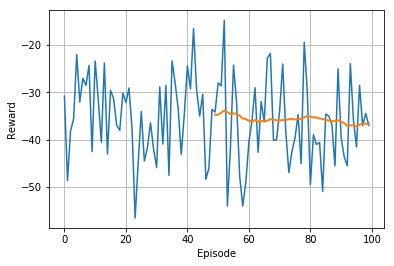

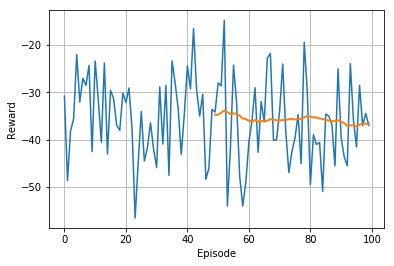

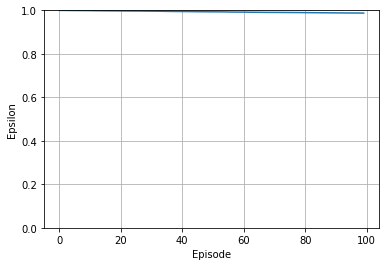

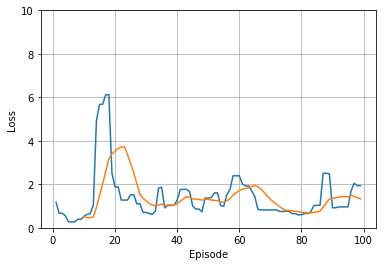

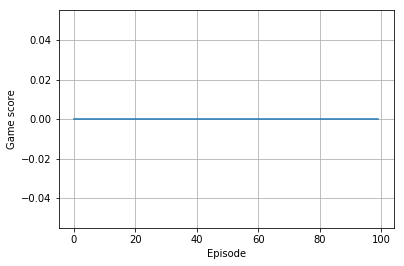

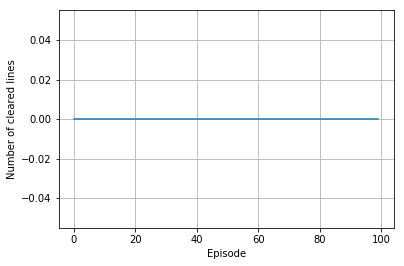

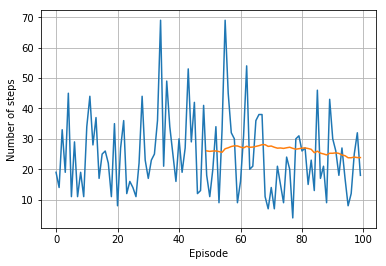


Consider using a TensorFlow optimizer from `tf.train`.

Consider using a TensorFlow optimizer from `tf.train`.
Model weights saved succesfully
episode 100 ended after: 27 steps and 2 sec., total reward is: -13 
Epsilon=0.987375331742784. Avg q-value prediction NRMSE=1.202305471277133
episode 101 ended after: 30 steps and 2 sec., total reward is: -26 
Epsilon=0.9872272361802275. Avg q-value prediction NRMSE=0.9625841361335484
episode 102 ended after: 21 steps and 0 sec., total reward is: -32 
Epsilon=0.9871235825032066. Avg q-value prediction NRMSE=0.9625841361335484
episode 103 ended after: 34 steps and 2 sec., total reward is: -39 
Epsilon=0.9869557853378499. Avg q-value prediction NRMSE=1.0067054845278844
episode 104 ended after: 22 steps and 2 sec., total reward is: -30 
Epsilon=0.9868472259009416. Avg q-value prediction NRMSE=0.9837513223627882
episode 105 ended after: 12 steps and 2 sec., total reward is: -33 
Epsilon=0.9867880166956581. Avg q-value prediction NRMSE=0.79978666948

episode 152 ended after: 20 steps and 2 sec., total reward is: -43 
Epsilon=0.9810370499340132. Avg q-value prediction NRMSE=1.3690442101070648
episode 153 ended after: 20 steps and 2 sec., total reward is: -32 
Epsilon=0.9809389508888054. Avg q-value prediction NRMSE=1.1971568205110936
episode 154 ended after: 37 steps and 2 sec., total reward is: -29 
Epsilon=0.9807574935145704. Avg q-value prediction NRMSE=1.1243035033314994
episode 155 ended after: 17 steps and 0 sec., total reward is: -29 
Epsilon=0.9806741324621132. Avg q-value prediction NRMSE=1.1243035033314994
episode 156 ended after: 18 steps and 2 sec., total reward is: -17 
Epsilon=0.9805858755411698. Avg q-value prediction NRMSE=1.0412656593763254
episode 157 ended after: 34 steps and 2 sec., total reward is: -29 
Epsilon=0.9804191896943102. Avg q-value prediction NRMSE=1.4718569486504562
episode 158 ended after: 44 steps and 2 sec., total reward is: -39 
Epsilon=0.9802035206578665. Avg q-value prediction NRMSE=1.493554595

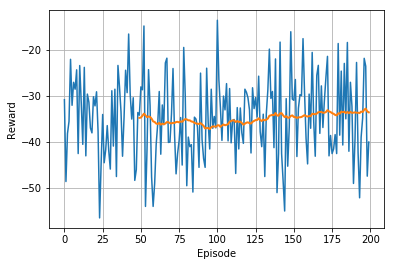

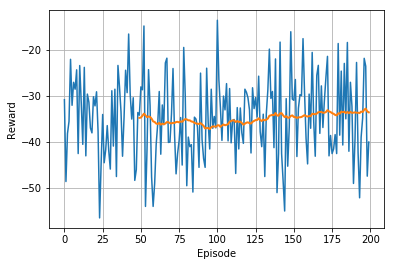

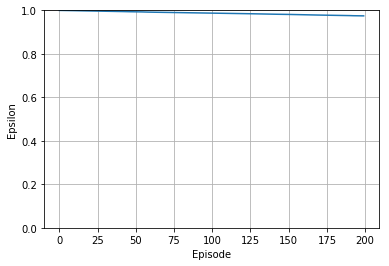

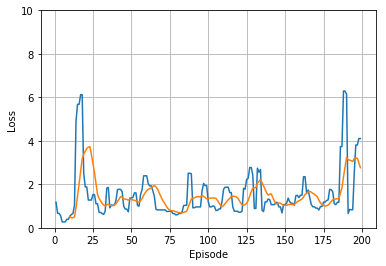

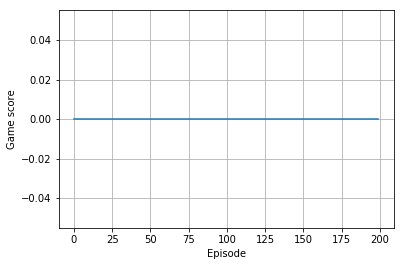

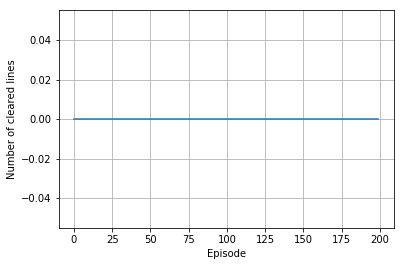

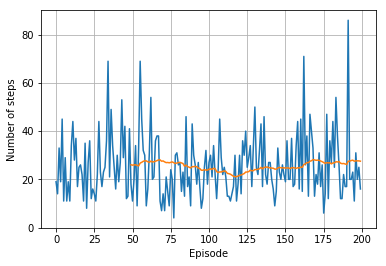


Consider using a TensorFlow optimizer from `tf.train`.

Consider using a TensorFlow optimizer from `tf.train`.
Model weights saved succesfully
episode 200 ended after: 20 steps and 2 sec., total reward is: -42 
Epsilon=0.9745737635700304. Avg q-value prediction NRMSE=2.482864567370603
episode 201 ended after: 44 steps and 2 sec., total reward is: -16 
Epsilon=0.9743593803890999. Avg q-value prediction NRMSE=2.8711811085706347
episode 202 ended after: 23 steps and 2 sec., total reward is: -47 
Epsilon=0.9742473352229618. Avg q-value prediction NRMSE=2.4986147403569894
episode 203 ended after: 12 steps and 0 sec., total reward is: -45 
Epsilon=0.9741888819903294. Avg q-value prediction NRMSE=2.4986147403569894
episode 204 ended after: 8 steps and 2 sec., total reward is: -34 
Epsilon=0.9741499151169749. Avg q-value prediction NRMSE=2.4903344172421327
episode 205 ended after: 46 steps and 2 sec., total reward is: -17 
Epsilon=0.9739258858407771. Avg q-value prediction NRMSE=1.58563321955

episode 252 ended after: 52 steps and 4 sec., total reward is: -31 
Epsilon=0.9675820154903818. Avg q-value prediction NRMSE=1.334068535259117
episode 253 ended after: 12 steps and 0 sec., total reward is: -35 
Epsilon=0.9675239621659358. Avg q-value prediction NRMSE=1.334068535259117
episode 254 ended after: 51 steps and 4 sec., total reward is: -31 
Epsilon=0.9672772743928898. Avg q-value prediction NRMSE=1.397445957335891
episode 255 ended after: 43 steps and 2 sec., total reward is: -28 
Epsilon=0.9670693316136861. Avg q-value prediction NRMSE=0.7753075023350007
episode 256 ended after: 42 steps and 2 sec., total reward is: -33 
Epsilon=0.9668662678688255. Avg q-value prediction NRMSE=0.851198317890139
episode 257 ended after: 22 steps and 2 sec., total reward is: -44 
Epsilon=0.9667599181628259. Avg q-value prediction NRMSE=0.9313457850298658
episode 258 ended after: 21 steps and 0 sec., total reward is: -38 
Epsilon=0.9666584134467471. Avg q-value prediction NRMSE=0.9313457850298

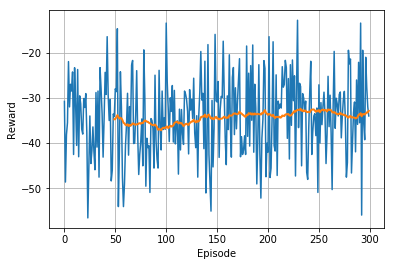

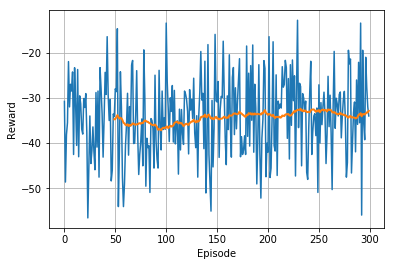

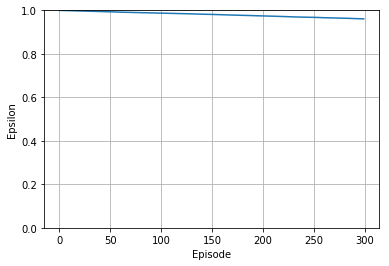

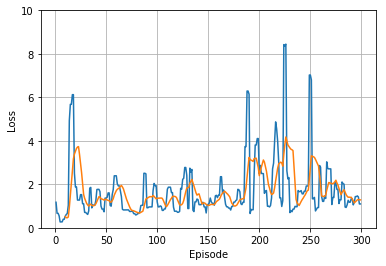

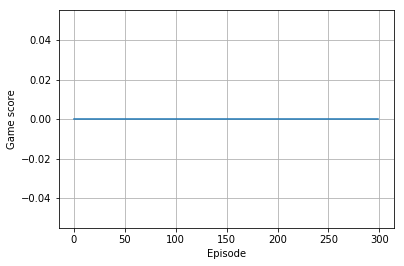

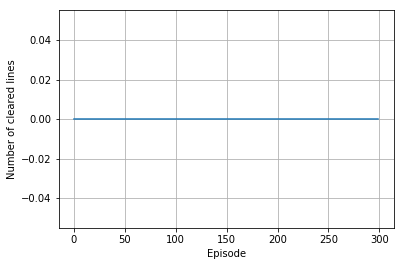

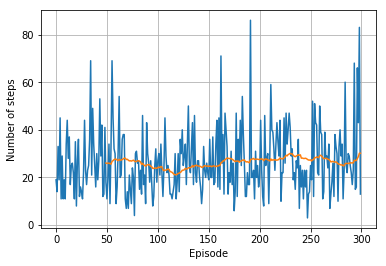


Consider using a TensorFlow optimizer from `tf.train`.

Consider using a TensorFlow optimizer from `tf.train`.
Model weights saved succesfully
episode 300 ended after: 21 steps and 2 sec., total reward is: -25 
Epsilon=0.9606788538115947. Avg q-value prediction NRMSE=1.9956752483461886
episode 301 ended after: 49 steps and 4 sec., total reward is: -33 
Epsilon=0.960443515734155. Avg q-value prediction NRMSE=5.306233511211457
episode 302 ended after: 52 steps and 2 sec., total reward is: -34 
Epsilon=0.9601938322561122. Avg q-value prediction NRMSE=4.573490882868566
episode 303 ended after: 33 steps and 2 sec., total reward is: -39 
Epsilon=0.9600354129476926. Avg q-value prediction NRMSE=4.46662156951232
episode 304 ended after: 22 steps and 2 sec., total reward is: -19 
Epsilon=0.9599298145962871. Avg q-value prediction NRMSE=0.8972421377950337
episode 305 ended after: 22 steps and 0 sec., total reward is: -31 
Epsilon=0.9598242278600908. Avg q-value prediction NRMSE=0.89724213779503

KeyboardInterrupt: 

In [15]:
import copy

# initialising agent and game
tetris_env = TetrisEngine()
agent = Agent(epsilon, epsilon_min, epsilon_decay, decay_change, epsilon_decay2)
memory_filter = MemoryFilter(agent)

DONE_PENALTY = 0
NUMBER_OF_EPISODES = 20000
champion_score = -10e6

total_rewards = []
custom_rewards = []
epsilons = []
losses = []
scores = []
lines = []
steps = []

# iterate over episodes
print("Starting %d episodes: " % NUMBER_OF_EPISODES)
for ep in range(NUMBER_OF_EPISODES):

  current_state = tetris_env.reset()
  cond = (ep+1)%100==0
  cur_step = 0
  done = False
  last_engine_reward = 0
  tot_reward = 0
  tot_custom_reward = 0
  new_block = True

  if(cond):
    vid = cv2.VideoWriter(SRC_PATH+'/GM2_0_Gamma_0_5_'+str(ep+1)+'.avi',cv2.VideoWriter_fourcc(*'XVID'), 15, (250, 500))
    #vid = cv2.VideoWriter('tetris_'+str(ep+1)+'.avi',cv2.VideoWriter_fourcc(*'XVID'), 15, (250, 500))

  # iterate over gamesteps
  start = time.time()
  while True:

    cur_step+=1

    # Render the game state
    if(cond): #only save last episode to save processing time
      frame = tetris_env.render()
      vid.write(frame)

    action = agent.get_action(current_state.reshape(1,20,10,1))
    previous_state = current_state
    current_state, last_engine_reward, done, info = tetris_env.step(INPUT_MAP(action))
    new_block = info["new_block"]
      
    # if there is a new piece
    if (new_block or done):
      our_custom_reward, done = custom_reward5(previous_state, current_state)
      reward = our_custom_reward + last_engine_reward
      tot_reward+=reward
      tot_custom_reward+=our_custom_reward
      if done:
          memory_filter.remember(True, [previous_state, action, reward-DONE_PENALTY, current_state, done])
      else:
          memory_filter.remember(True, [previous_state, action, reward, current_state, done])

      if (done):
        end = time.time()
        total_rewards.append(tot_reward)
        custom_rewards.append(tot_custom_reward)
        print("episode %d ended after: %d steps and %d sec., total reward is: %d " % (ep, cur_step, end-start, tot_reward))
        epsilon, loss = agent.log()
        epsilons.append(epsilon)
        losses.append(loss)
        scores.append(info['score'])
        lines.append(info['number_of_lines'])
        steps.append(cur_step)

        if (tot_reward > champion_score):
          champion_score = tot_reward

        if(cond):
          vid.release()
          print(previous_state)
          make_plots(total_rewards, custom_rewards, epsilons, losses, scores, lines, steps)
          agent.save_agent_state(ep, "model_weights_Gamma_0_5", "replay_buffer_Gamma_0_5")
        
        break

    else:
      memory_filter.remember(True, [previous_state, action, 0, current_state, done])   
       
print("The best score achieved equals %d" % champion_score)
make_plots(total_rewards, custom_rewards, epsilons, losses, scores, lines, steps)
agent.save_agent_state(ep, "model_weights_Gamma_0_5", "replay_buffer_Gamma_0_5")